### 연습

In [2]:
import FinanceDataReader as fdr
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb

# KOSPI 데이터에서 주식 코드 추출
# KOSPI = fdr.StockListing('KOSPI')
# stock_codes = KOSPI['Code'].tolist()

# 사용하고 싶은 주식 코드의 수를 제한 
# stock_codes = stock_codes[:100]
# 분석할 주식 코드 목록
stock_codes = ['041190', '015750']

# 빈 리스트를 만들어서 모든 주식 데이터를 통합할 준비
X = []
Y = []

# 각 주식 코드에 대해 데이터 불러오고 처리
for code in stock_codes:
    try:
        df = fdr.DataReader(code).dropna()  # 데이터 불러오기 및 결측값 제거
        
        # 주식 데이터가 비어있지 않은 경우에만 처리
        if not df.empty:
            close_prices = df['Close'].values

            # 지수 이동 평균 (EMA) 및 MACD 계산
            ema_12 = pd.Series(close_prices).ewm(span=12, adjust=False).mean().values
            ema_26 = pd.Series(close_prices).ewm(span=26, adjust=False).mean().values
            ema_50 = pd.Series(close_prices).ewm(span=50, adjust=False).mean().values
            ema_200 = pd.Series(close_prices).ewm(span=200, adjust=False).mean().values

            macd = ema_12 - ema_26
            signal_line = pd.Series(macd).ewm(span=9, adjust=False).mean().values

            # 윈도우 사이즈와 예측 기간 설정
            window_size = 10  # 윈도우 사이즈 (일수)
            next_date = 1     # 예측 기간 (일수)

            for i in range(len(close_prices) - window_size - next_date):
                window = close_prices[i:i + window_size]
                
                # EMA 및 MACD 지표 추가
                ema_window = ema_50[i:i + window_size]
                macd_window = macd[i:i + window_size]
                signal_window = signal_line[i:i + window_size]
                
                # 특성 벡터 생성
                features = np.concatenate([ema_window, macd_window, signal_window])
                
                # Signals 계산
                signals = [2]  # 초기값 (교차 없음)
                for j in range(1, len(macd)):
                    if ((macd[j-1] < signal_line[j-1]) and (macd[j] > signal_line[j])) or \
                       ((ema_50[j-1] < ema_200[j-1]) and (ema_50[j] > ema_200[j])):
                        signals.append(1)  # 매수 신호
                    elif ((macd[j-1] > signal_line[j-1]) and (macd[j] < signal_line[j])) or \
                         ((ema_50[j-1] > ema_200[j-1]) and (ema_50[j] < ema_200[j])):
                        signals.append(0)  # 매도 신호
                    else:
                        signals.append(2)  # 교차 없음
                
                # 타겟 값을 현재 윈도우의 마지막 인덱스에 대해 설정
                if i + window_size + next_date < len(signals):
                    target = signals[i + window_size + next_date]
                    X.append(features)
                    Y.append(target)
                
    except Exception as e:
        print(f"Error processing code {code}: {e}")

# X와 Y를 numpy 배열로 변환
X = np.array(X)
Y = np.array(Y)




In [8]:
# 데이터 분할 (훈련 데이터와 테스트 데이터)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)

# XGBoost 분류 모델 생성 및 학습
model = xgb.XGBClassifier(
    objective='binary:logistic', 
    eval_metric='logloss', 
    learning_rate=0.1, 
    n_estimators=100, 
    max_depth=5, 
    subsample=0.8, 
    colsample_bytree=0.8,
    scale_pos_weight=1,
    random_state=42
)
model.fit(X_train, Y_train)

# 테스트 데이터에 대해 예측 수행
Y_pred = model.predict(X_test)

# 모델 평가
accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy}')

conf_matrix = confusion_matrix(Y_test, Y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

class_report = classification_report(Y_test, Y_pred)
print(f'Classification Report:\n{class_report}')

# 예측 결과 확인
print('Sample Predictions:')
for i in range(min(5, len(Y_pred))):
    print(f'Actual: {Y_test[i]}, Predicted: {Y_pred[i]}')


C:\Users\campus4D046\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:26:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.904642409033877
Confusion Matrix:
[[   0    0  111]
 [   0    0  117]
 [   0    0 2163]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       111
           1       0.00      0.00      0.00       117
           2       0.90      1.00      0.95      2163

    accuracy                           0.90      2391
   macro avg       0.30      0.33      0.32      2391
weighted avg       0.82      0.90      0.86      2391

Sample Predictions:
Actual: 2, Predicted: 2
Actual: 2, Predicted: 2
Actual: 2, Predicted: 2
Actual: 2, Predicted: 2
Actual: 2, Predicted: 2


C:\Users\campus4D046\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\campus4D046\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\campus4D046\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


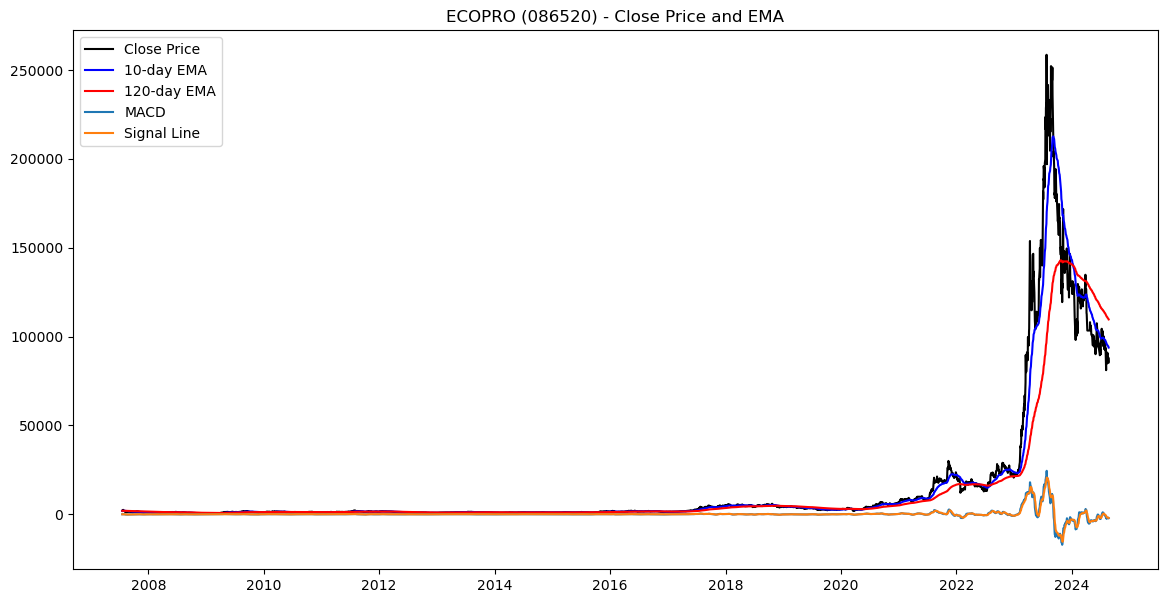

In [10]:
# EMA(지수이동평균) 추가하기
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
ecopro = fdr.DataReader('086520')
close_prices = ecopro['Close']
ema_50 = close_prices.ewm(span=50, adjust=False).mean()
ecopro['ema_50'] = ema_50
ema_12 = close_prices.ewm(span=12, adjust=False).mean()
ecopro['ema_12'] = ema_12
ema_26 = close_prices.ewm(span=26, adjust=False).mean()
ecopro['ema_26'] = ema_26
ema_200 = close_prices.ewm(span=200, adjust=False).mean()
ecopro['ema_200'] = ema_200
ecopro['MACD'] = ecopro['ema_12'] - ecopro['ema_26']
ecopro['Signal Line'] = ecopro['MACD'].ewm(span=9, adjust=False).mean()
# 결과 시각화
plt.figure(figsize=(14,7))
plt.plot(close_prices, label='Close Price', color='black')
plt.plot(ema_50, label='10-day EMA', color='blue')
plt.plot(ema_200, label='120-day EMA', color='red')
plt.plot(ecopro['MACD'], label='MACD')
plt.plot(ecopro['Signal Line'], label='Signal Line')
plt.title('ECOPRO (086520) - Close Price and EMA')
plt.legend(loc='upper left')
plt.show()
signals = [2]
for i in range(1, len(ecopro)):
        if ((ecopro['MACD'].iloc[i-1] < ecopro['Signal Line'].iloc[i-1]) and (ecopro['MACD'].iloc[i] > ecopro['Signal Line'].iloc[i])) or \
        ((ecopro['ema_50'].iloc[i-1] < ecopro['ema_200'].iloc[i-1]) and (ecopro['ema_50'].iloc[i] > ecopro['ema_200'].iloc[i])):
            signals.append(1)  # 매수 신호
        elif ((ecopro['MACD'].iloc[i-1] > ecopro['Signal Line'].iloc[i-1]) and (ecopro['MACD'].iloc[i] < ecopro['Signal Line'].iloc[i])) or \
        ((ecopro['ema_50'].iloc[i-1] > ecopro['ema_200'].iloc[i-1]) and (ecopro['ema_50'].iloc[i] < ecopro['ema_200'].iloc[i])):
            signals.append(0)  # 매도 신호
        else:
            signals.append(2)  # 교차 없음
ecopro['Signal'] = signals
ecopro1 = ecopro.iloc[1:, :]

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 분석에 사용할 컬럼 선택
features = ecopro1[[ 'Open', 'High', 'Low', 'Close', 'Volume', 'Change','ema_50', 'ema_12', 'ema_26', 'ema_200', 'MACD', 'Signal Line']]

# VIF 계산
vif_data = pd.DataFrame()
vif_data["Feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]

print(vif_data)


        Feature          VIF
0          Open  2490.479801
1          High  1164.453068
2           Low  1376.412975
3         Close  1114.755559
4        Volume     1.189276
5        Change     1.241081
6        ema_50  6091.999946
7        ema_12          inf
8        ema_26          inf
9       ema_200    80.039212
10         MACD          inf
11  Signal Line   118.687858


C:\Users\campus4D046\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [17]:
df =pd.read_csv('krx/stocks/삼성전기.csv')
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Change'], dtype='object')

In [ ]:
'041190', '015750'

In [29]:
import FinanceDataReader as fdr
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb

# 분석할 주식 코드 목록
stock_codes = ['005930']

# 빈 리스트를 만들어서 모든 주식 데이터를 통합할 준비
X = []
Y = []

# 각 주식 코드에 대해 데이터 불러오고 처리
for code in stock_codes:
    try:
        df = fdr.DataReader(code).dropna()  # 데이터 불러오기 및 결측값 제거
        
        # 주식 데이터가 비어있지 않은 경우에만 처리
        if not df.empty:
            df['Change'] = df['Close'].pct_change()  # 가격 변화율 계산
            df = df.dropna()  # NaN 값 제거

            # 특성 벡터 생성 (Open, High, Low, Close, Volume, Change 값)
            features = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Change']].values


            # 지수 이동 평균 (EMA) 및 MACD 계산
            ema_12 = pd.Series(df['Close']).ewm(span=12, adjust=False).mean().values
            ema_26 = pd.Series(df['Close']).ewm(span=26, adjust=False).mean().values
            ema_50 = pd.Series(df['Close']).ewm(span=50, adjust=False).mean().values
            ema_200 = pd.Series(df['Close']).ewm(span=200, adjust=False).mean().values

            macd = ema_12 - ema_26
            signal_line = pd.Series(macd).ewm(span=9, adjust=False).mean().values

            # Signals 계산
            signals = np.zeros(len(macd))
            for j in range(1, len(macd)):
                if ((macd[j-1] < signal_line[j-1]) and (macd[j] > signal_line[j])) or \
                   ((ema_50[j-1] < ema_200[j-1]) and (ema_50[j] > ema_200[j])):
                    signals[j] = 1  # 매수 신호
                elif ((macd[j-1] > signal_line[j-1]) and (macd[j] < signal_line[j])) or \
                     ((ema_50[j-1] > ema_200[j-1]) and (ema_50[j] < ema_200[j])):
                    signals[j] = 0  # 매도 신호
                else:
                    signals[j] = 2  # 교차 없음
            
            # 데이터 추가 (특성 및 타겟 값)
            for i in range(len(signals)):
                # 특성 벡터 생성 (Open, High, Low, Close, Volume, Change 값)
                features_i = features[i, :] if i < len(features) else np.zeros(features.shape[1])
                X.append(features_i)
                Y.append(signals[i])
                
    except Exception as e:
        print(f"Error processing code {code}: {e}")

# X와 Y를 numpy 배열로 변환
X = np.array(X)
Y = np.array(Y)

In [31]:
import FinanceDataReader as fdr
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

# 데이터 분할 (훈련 데이터와 테스트 데이터)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)

# 랜덤 포레스트 모델 생성 및 학습
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42
)
model.fit(X_train, Y_train)

# 테스트 데이터에 대해 예측 수행
Y_pred = model.predict(X_test)

# 모델 평가
accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy}')

conf_matrix = confusion_matrix(Y_test, Y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

class_report = classification_report(Y_test, Y_pred)
print(f'Classification Report:\n{class_report}')

Accuracy: 0.9260960334029228
Confusion Matrix:
[[   0    0  100]
 [   0    0   77]
 [   0    0 2218]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       100
         1.0       0.00      0.00      0.00        77
         2.0       0.93      1.00      0.96      2218

    accuracy                           0.93      2395
   macro avg       0.31      0.33      0.32      2395
weighted avg       0.86      0.93      0.89      2395



C:\Users\campus4D046\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\campus4D046\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\campus4D046\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
# 새 데이터
new_data = np.array([79400, 80200, 78700, 80200, 22061478, 3000]).reshape(1, -1)

# 랜덤 포레스트 모델로 예측 수행
predicted_signal = model.predict(new_data)

print(f'Predicted Signal: {predicted_signal[0]}')

# 예측 결과 해석
signal_map = {0: 'Sell', 1: 'Buy', 2: 'No Signal'}
print(f'Interpreted Signal: {signal_map[predicted_signal[0]]}')

Predicted Signal: 2.0
Interpreted Signal: No Signal


### 기업별 모델링 
- 기능 기업별 모델링 파일 저장
- 기업(Code) , 새 데이터 입력 -> signal 예측

In [44]:
import FinanceDataReader as fdr
import numpy as np
import pandas as pd
import xgboost as xgb
import joblib  # For saving and loading models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 분석할 주식 코드 목록
stock_codes = ['041190', '015750']

# 각 기업별 모델을 저장할 딕셔너리
models = {}

for code in stock_codes:
    try:
        df = fdr.DataReader(code).dropna()  # 데이터 불러오기 및 결측값 제거
        
        if not df.empty:
            df['Change'] = df['Close'].pct_change()  # 가격 변화율 계산
            df = df.dropna()  # NaN 값 제거

            # 특성 벡터 생성 (Open, High, Low, Close, Volume, Change 값)
            features = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Change']].values

            # 지수 이동 평균 (EMA) 및 MACD 계산
            ema_12 = pd.Series(df['Close']).ewm(span=12, adjust=False).mean().values
            ema_26 = pd.Series(df['Close']).ewm(span=26, adjust=False).mean().values
            ema_50 = pd.Series(df['Close']).ewm(span=50, adjust=False).mean().values
            ema_200 = pd.Series(df['Close']).ewm(span=200, adjust=False).mean().values

            macd = ema_12 - ema_26
            signal_line = pd.Series(macd).ewm(span=9, adjust=False).mean().values

            # Signals 계산
            signals = np.zeros(len(macd))
            for j in range(1, len(macd)):
                if ((macd[j-1] < signal_line[j-1]) and (macd[j] > signal_line[j])) or \
                   ((ema_50[j-1] < ema_200[j-1]) and (ema_50[j] > ema_200[j])):
                    signals[j] = 1  # 매수 신호
                elif ((macd[j-1] > signal_line[j-1]) and (macd[j] < signal_line[j])) or \
                     ((ema_50[j-1] > ema_200[j-1]) and (ema_50[j] < ema_200[j])):
                    signals[j] = 0  # 매도 신호
                else:
                    signals[j] = 2  # 교차 없음
            
            # 데이터 추가 (특성 및 타겟 값)
            X = features
            Y = signals

            # 데이터 분할 (훈련 데이터와 테스트 데이터)
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)

            # XGBoost 분류 모델 생성 및 학습
            model = xgb.XGBClassifier(
                objective='multi:softmax',
                eval_metric='mlogloss',
                learning_rate=0.1,
                n_estimators=100,
                max_depth=5,
                subsample=0.8,
                colsample_bytree=0.8,
                num_class=3,  # 클래스 수 (매수, 매도, 신호 없음)
                random_state=42
            )
            model.fit(X_train, Y_train)

            # 테스트 데이터에 대해 예측 수행
            Y_pred = model.predict(X_test)

            # 모델 평가
            accuracy = accuracy_score(Y_test, Y_pred)
            conf_matrix = confusion_matrix(Y_test, Y_pred)
            class_report = classification_report(Y_test, Y_pred)

            # 모델 저장
            model_filename = f'model_{code}.joblib'
            joblib.dump(model, model_filename)
            models[code] = model_filename
            

            # 결과 출력
            print(f"Model for code {code} saved as {model_filename}")
            print(f"Accuracy for code {code}: {accuracy}")
            print(f"Confusion Matrix for code {code}:\n{conf_matrix}")
            print(f"Classification Report for code {code}:\n{class_report}")

    except Exception as e:
        print(f"Error processing code {code}: {e}")


C:\Users\campus4D046\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\campus4D046\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\campus4D046\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model for code 041190 saved as model_041190.joblib
Accuracy for code 041190: 0.9171548117154812
Confusion Matrix for code 041190:
[[   0    0   47]
 [   0    0   52]
 [   0    0 1096]]
Classification Report for code 041190:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        47
         1.0       0.00      0.00      0.00        52
         2.0       0.92      1.00      0.96      1096

    accuracy                           0.92      1195
   macro avg       0.31      0.33      0.32      1195
weighted avg       0.84      0.92      0.88      1195

Model for code 015750 saved as model_015750.joblib
Accuracy for code 015750: 0.9141666666666667
Confusion Matrix for code 015750:
[[   0    0   54]
 [   0    0   48]
 [   0    1 1097]]
Classification Report for code 015750:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        54
         1.0       0.00      0.00      0.00        48
        

C:\Users\campus4D046\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\campus4D046\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\campus4D046\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
import joblib  # For saving and loading models
import numpy as np

# 특정 기업 코드
company_code = '041190'  # Replace with the desired code

# 새 데이터
new_data = np.array([79400, 80200, 78700, 80200, 22061478, 3000]).reshape(1, -1)

# 기업 코드에 맞는 모델 파일명
model_filename = f'model_{company_code}.joblib'

try:
    # 모델 불러오기
    model = joblib.load(model_filename)
    
    # 예측 수행
    predicted_signal = model.predict(new_data)
    
    # 예측 결과 해석
    signal_map = {0: 'Sell', 1: 'Buy', 2: 'No Signal'}
    print(f'For company code {company_code}, the predicted signal is {signal_map[predicted_signal[0]]}')
    
except FileNotFoundError:
    print(f"Model file for code {company_code} not found.")
except Exception as e:
    print(f"Error during prediction: {e}")


For company code 041190, the predicted signal is No Signal


### 기업별 모델링2

#### 시그널 value_count

In [29]:
import FinanceDataReader as fdr
import numpy as np
import pandas as pd
import xgboost as xgb
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
df = fdr.DataReader('015750').dropna()

 # 가격 변화율 계산
df['Change'] = df['Close'].pct_change()
df = df.dropna()

# EMA 계산 및 MACD, Signal Line 생성
df['ema_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['ema_12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['ema_26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['ema_30'] = df['Close'].ewm(span=30, adjust=False).mean()
df['MACD'] = df['ema_12'] - df['ema_26']
df['Signal Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Signals 계산
signals = [2]  # 첫 번째 신호는 비교할 이전 데이터가 없기 때문에 2로 설정
for i in range(1, len(df)):
    if ((df['MACD'].iloc[i-1] < df['Signal Line'].iloc[i-1]) and (df['MACD'].iloc[i] > df['Signal Line'].iloc[i])) or \
       ((df['ema_10'].iloc[i-1] < df['ema_30'].iloc[i-1]) and (df['ema_10'].iloc[i] > df['ema_30'].iloc[i])):
        signals.append(1)  # 매수 신호
    elif ((df['MACD'].iloc[i-1] > df['Signal Line'].iloc[i-1]) and (df['MACD'].iloc[i] < df['Signal Line'].iloc[i])) or \
         ((df['ema_10'].iloc[i-1] > df['ema_30'].iloc[i-1]) and (df['ema_10'].iloc[i] < df['ema_30'].iloc[i])):
        signals.append(0)  # 매도 신호
    else:
        signals.append(2)  # 교차 없음
df['Signal'] = signals

# Position 열 초기화
df['Position'] = 0
for i in range(0, len(df), 100):
    avg_volume = df.iloc[i:i+100]['Volume'].mean()
    df.iloc[i:i+100, df.columns.get_loc('Position')] = np.where(df.iloc[i:i+100]['Volume'] > avg_volume, 1, 0)

# 매수/매도 신호 업데이트
df['Signal'] = np.where((df['Position'] == 1) & (df['Change'] < 0), 1, df['Signal'])  # 매수
df['Signal'] = np.where((df['Position'] == 1) & (df['Change'] > 0), 0, df['Signal'])  # 매도

# 볼린저 밴드 계산
window = 5  # 이동평균 기간
df['SMA'] = df['Close'].rolling(window=window).mean()  # 단순 이동평균
df['STD'] = df['Close'].rolling(window=window).std()   # 표준편차
df['Upper Band'] = df['SMA'] + (df['STD'] * 1.2)       # 상단 밴드
df['Lower Band'] = df['SMA'] - (df['STD'] * 1.2)      # 하단 밴드

# 결측값 제거
df = df.dropna()

# Position2 및 Position3 열 초기화
df[['Position2', 'Position3']] = 0

# 과매수 및 과매도 구간
df['Position2'] = np.where(df['Close'] >= df['Upper Band'], 1, df['Position2'])  # 과매수 구간
df['Position3'] = np.where(df['Close'] <= df['Lower Band'], 1, df['Position3'])  # 과매도 구간

# 매수/매도 신호 업데이트
df['Signal'] = np.where(df['Position2'] == 1, 0, df['Signal'])  # 매도 추천
df['Signal'] = np.where(df['Position3'] == 1, 1, df['Signal'])  # 매수 추천

# 불필요한 열 제거
columns_to_remove = ['ema_10', 'ema_12', 'ema_26', 'ema_30', 'MACD', 'Signal Line', 'Position']
df = df.drop(columns=columns_to_remove)

# 다시 NaN 값 제거
df = df.dropna()

In [31]:
df['Signal'].value_counts()

Signal
2    2856
1    1600
0    1538
Name: count, dtype: int64

In [97]:
(3487/3487 + 1383 + 1128)

2512.0

In [99]:
(1383/3487 + 1383 + 1128)

2511.396616002294

#### 기업별 모델링

In [138]:
import FinanceDataReader as fdr
import numpy as np
import pandas as pd
import xgboost as xgb
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

# 분석할 주식 코드 목록
stock_codes = ['086520', '035890', '036220']

# 각 기업별 모델을 저장할 딕셔너리
models = {}

for code in stock_codes:
    try:
        df = fdr.DataReader(code).dropna()  # 데이터 불러오기 및 결측값 제거
        df.drop(['2024-08-22'])
        if not df.empty:
            # 가격 변화율 계산
            df['Change'] = df['Close'].pct_change()
            df = df.dropna()
            
            # EMA 계산 및 MACD, Signal Line 생성
            df['ema_10'] = df['Close'].ewm(span=10, adjust=False).mean()
            df['ema_12'] = df['Close'].ewm(span=12, adjust=False).mean()
            df['ema_26'] = df['Close'].ewm(span=26, adjust=False).mean()
            df['ema_30'] = df['Close'].ewm(span=30, adjust=False).mean()
            df['MACD'] = df['ema_12'] - df['ema_26']
            df['Signal Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
            
            # Signals 계산
            signals = [2]  # 첫 번째 신호는 비교할 이전 데이터가 없기 때문에 2로 설정
            for i in range(1, len(df)):
                if ((df['MACD'].iloc[i-1] < df['Signal Line'].iloc[i-1]) and (df['MACD'].iloc[i] > df['Signal Line'].iloc[i])) or \
                   ((df['ema_10'].iloc[i-1] < df['ema_30'].iloc[i-1]) and (df['ema_10'].iloc[i] > df['ema_30'].iloc[i])):
                    signals.append(1)  # 매수 신호
                elif ((df['MACD'].iloc[i-1] > df['Signal Line'].iloc[i-1]) and (df['MACD'].iloc[i] < df['Signal Line'].iloc[i])) or \
                     ((df['ema_10'].iloc[i-1] > df['ema_30'].iloc[i-1]) and (df['ema_10'].iloc[i] < df['ema_30'].iloc[i])):
                    signals.append(0)  # 매도 신호
                else:
                    signals.append(2)  # 교차 없음
            df['Signal'] = signals
            
            # Position 열 초기화
            df['Position'] = 0
            for i in range(0, len(df), 100):
                avg_volume = df.iloc[i:i+100]['Volume'].mean()
                df.iloc[i:i+100, df.columns.get_loc('Position')] = np.where(df.iloc[i:i+100]['Volume'] > avg_volume, 1, 0)
            
            # 매수/매도 신호 업데이트
            df['Signal'] = np.where((df['Position'] == 1) & (df['Change'] < 0), 1, df['Signal'])  # 매수
            df['Signal'] = np.where((df['Position'] == 1) & (df['Change'] > 0), 0, df['Signal'])  # 매도
            
            # 볼린저 밴드 계산
            window = 5  # 이동평균 기간
            df['SMA'] = df['Close'].rolling(window=window).mean()  # 단순 이동평균
            df['STD'] = df['Close'].rolling(window=window).std()   # 표준편차
            df['Upper Band'] = df['SMA'] + (df['STD'] * 1.2)       # 상단 밴드
            df['Lower Band'] = df['SMA'] - (df['STD'] * 1.2)      # 하단 밴드
            
            # 결측값 제거
            df = df.dropna()
            
            # Position2 및 Position3 열 초기화
            df[['Position2', 'Position3']] = 0
            
            # 과매수 및 과매도 구간
            df['Position2'] = np.where(df['Close'] >= df['Upper Band'], 1, df['Position2'])  # 과매수 구간
            df['Position3'] = np.where(df['Close'] <= df['Lower Band'], 1, df['Position3'])  # 과매도 구간
            
            # 매수/매도 신호 업데이트
            df['Signal'] = np.where(df['Position2'] == 1, 0, df['Signal'])  # 매도 추천
            df['Signal'] = np.where(df['Position3'] == 1, 1, df['Signal'])  # 매수 추천
            
            # 불필요한 열 제거
            columns_to_remove = ['ema_10', 'ema_12', 'ema_26', 'ema_30', 'MACD', 'Signal Line', 'Position']
            df = df.drop(columns=columns_to_remove)
            
            # 다시 NaN 값 제거
            df = df.dropna()

            #
            # 윈도우 슬라이싱을 통해 2차원 입력 데이터 생성
            window = 1000  # 5일 동안의 데이터를 사용
            X, y = [], []
            for i in range(window, len(df)):
                X.append(df[['Open', 'High', 'Low', 'Close', 'Volume', 'Change']].iloc[i-window:i].values.flatten())
                y.append(df['Signal'].iloc[i])

            X = np.array(X)
            y = np.array(y)

            # 데이터 분할 (훈련 데이터와 테스트 데이터)
            X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42, stratify=y)
            #
            
            # # 특성 벡터와 타겟 벡터 설정
            # features = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Change']].values
            # targets = df['Signal'].values

            # # 데이터 분할 (훈련 데이터와 테스트 데이터)
            # X_train, X_test, Y_train, Y_test = train_test_split(features, targets, test_size=0.3, shuffle=True, random_state=42,stratify=targets)
            
            # 클래스 가중치 계산
            classes = np.unique(Y_train)
            class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=Y_train)
            class_weight_dict = dict(zip(classes, class_weights))
           
            # XGBoost 분류 모델 생성 및 학습
            model = xgb.XGBClassifier(
                objective='multi:softmax',
                eval_metric='mlogloss',
                learning_rate=0.1,
                n_estimators=100,
                max_depth=5,
                subsample=0.8,
                colsample_bytree=0.8,
                num_class=3,  # 클래스 수 (매수, 매도, 신호 없음)
                random_state=42,
                scale_pos_weight=class_weight_dict[1]  # 가중치 설정
            )
            model.fit(X_train, Y_train)

            # 테스트 데이터에 대해 예측 수행
            Y_pred = model.predict(X_test)

            # 모델 평가
            accuracy = accuracy_score(Y_test, Y_pred)
            conf_matrix = confusion_matrix(Y_test, Y_pred)
            class_report = classification_report(Y_test, Y_pred)

            # 모델 저장
            model_filename = f'model_{code}.joblib'
            joblib.dump(model, model_filename)
            models[code] = model_filename

            # 결과 출력
            print(f"Model for code {code} saved as {model_filename}")
            print(f"Accuracy for code {code}: {accuracy}")
            print(f"Confusion Matrix for code {code}:\n{conf_matrix}")
            print(f"Classification Report for code {code}:\n{class_report}")

    except Exception as e:
        print(f"Error processing code {code}: {e}")


C:\Users\campus4D046\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:36:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Model for code 086520 saved as model_086520.joblib
Accuracy for code 086520: 0.47357512953367875
Confusion Matrix for code 086520:
[[ 55  21 185]
 [ 41  31 187]
 [ 31  43 371]]
Classification Report for code 086520:
              precision    recall  f1-score   support

           0       0.43      0.21      0.28       261
           1       0.33      0.12      0.18       259
           2       0.50      0.83      0.62       445

    accuracy                           0.47       965
   macro avg       0.42      0.39      0.36       965
weighted avg       0.43      0.47      0.41       965



C:\Users\campus4D046\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:38:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Model for code 035890 saved as model_035890.joblib
Accuracy for code 035890: 0.52368245496998
Confusion Matrix for code 035890:
[[ 70  31 273]
 [ 52  64 275]
 [ 42  41 651]]
Classification Report for code 035890:
              precision    recall  f1-score   support

           0       0.43      0.19      0.26       374
           1       0.47      0.16      0.24       391
           2       0.54      0.89      0.67       734

    accuracy                           0.52      1499
   macro avg       0.48      0.41      0.39      1499
weighted avg       0.50      0.52      0.46      1499



C:\Users\campus4D046\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:41:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Model for code 036220 saved as model_036220.joblib
Accuracy for code 036220: 0.4810126582278481
Confusion Matrix for code 036220:
[[ 11  15  76]
 [ 11  42  65]
 [ 19  19 137]]
Classification Report for code 036220:
              precision    recall  f1-score   support

           0       0.27      0.11      0.15       102
           1       0.55      0.36      0.43       118
           2       0.49      0.78      0.60       175

    accuracy                           0.48       395
   macro avg       0.44      0.42      0.40       395
weighted avg       0.45      0.48      0.44       395



In [142]:
import joblib  # For saving and loading models
import FinanceDataReader as fdr
import numpy as np

# 특정 기업 코드
company_code = '035890'  # 예측을 수행할 주식 코드

# 데이터 불러오기
df = fdr.DataReader(company_code).dropna()
df.drop(['2024-08-22'])
# 최근 10일치 데이터 추출
window = 1000
new_data = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Change']].iloc[-window:].values.flatten()

# 데이터를 2D 형태로 변환 (모델 입력에 맞게)
new_data = new_data.reshape(1, -1)

# 기업 코드에 맞는 모델 파일명
model_filename = f'model_{company_code}.joblib'

try:
    # 모델 불러오기
    model = joblib.load(model_filename)
    
    # 예측 수행
    predicted_signal = model.predict(new_data)
    
    # 예측 결과 해석
    signal_map = {0: 'Sell', 1: 'Buy', 2: 'No Signal'}
    print(f'For company code {company_code}, the predicted signal is {signal_map[predicted_signal[0]]}')
    
except FileNotFoundError:
    print(f"Model file for code {company_code} not found.")
except Exception as e:
    print(f"Error during prediction: {e}")


For company code 035890, the predicted signal is Buy


## 코스닥 기업별 모델링

In [89]:
kosdak =pd.read_csv('KOSDAQ_result.csv')
kosdak.head()

,Code,Name,ROE,PER
0,41190,우리기술투자,26.51,4.92
1,15750,성우하이텍,13.63,3.41
2,215200,메가스터디교육,21.07,6.23
3,25980,아난티,17.47,4.44
4,95660,네오위즈,10.37,7.12


#### 회사 Signal 비율 확인

In [132]:
df = fdr.DataReader('041190').dropna()

 # 가격 변화율 계산
df['Change'] = df['Close'].pct_change()
df = df.dropna()

# EMA 계산 및 MACD, Signal Line 생성
df['ema_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['ema_12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['ema_26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['ema_30'] = df['Close'].ewm(span=30, adjust=False).mean()
df['MACD'] = df['ema_12'] - df['ema_26']
df['Signal Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Signals 계산
signals = [2]  # 첫 번째 신호는 비교할 이전 데이터가 없기 때문에 2로 설정
for i in range(1, len(df)):
    if ((df['MACD'].iloc[i-1] < df['Signal Line'].iloc[i-1]) and (df['MACD'].iloc[i] > df['Signal Line'].iloc[i])) or \
       ((df['ema_10'].iloc[i-1] < df['ema_30'].iloc[i-1]) and (df['ema_10'].iloc[i] > df['ema_30'].iloc[i])):
        signals.append(1)  # 매수 신호
    elif ((df['MACD'].iloc[i-1] > df['Signal Line'].iloc[i-1]) and (df['MACD'].iloc[i] < df['Signal Line'].iloc[i])) or \
         ((df['ema_10'].iloc[i-1] > df['ema_30'].iloc[i-1]) and (df['ema_10'].iloc[i] < df['ema_30'].iloc[i])):
        signals.append(0)  # 매도 신호
    else:
        signals.append(2)  # 교차 없음
df['Signal'] = signals

# Position 열 초기화
df['Position'] = 0
for i in range(0, len(df), 100):
    avg_volume = df.iloc[i:i+100]['Volume'].mean()
    df.iloc[i:i+100, df.columns.get_loc('Position')] = np.where(df.iloc[i:i+100]['Volume'] > avg_volume, 1, 0)

# 매수/매도 신호 업데이트
df['Signal'] = np.where((df['Position'] == 1) & (df['Change'] < 0), 1, df['Signal'])  # 매수
df['Signal'] = np.where((df['Position'] == 1) & (df['Change'] > 0), 0, df['Signal'])  # 매도

# 볼린저 밴드 계산
window = 5  # 이동평균 기간
df['SMA'] = df['Close'].rolling(window=window).mean()  # 단순 이동평균
df['STD'] = df['Close'].rolling(window=window).std()   # 표준편차
df['Upper Band'] = df['SMA'] + (df['STD'] * 1.2)       # 상단 밴드
df['Lower Band'] = df['SMA'] - (df['STD'] * 1.2)      # 하단 밴드

# 결측값 제거
df = df.dropna()

# Position2 및 Position3 열 초기화
df[['Position2', 'Position3']] = 0

# 과매수 및 과매도 구간
df['Position2'] = np.where(df['Close'] >= df['Upper Band'], 1, df['Position2'])  # 과매수 구간
df['Position3'] = np.where(df['Close'] <= df['Lower Band'], 1, df['Position3'])  # 과매도 구간

# 매수/매도 신호 업데이트
df['Signal'] = np.where(df['Position2'] == 1, 0, df['Signal'])  # 매도 추천
df['Signal'] = np.where(df['Position3'] == 1, 1, df['Signal'])  # 매수 추천

# 불필요한 열 제거
columns_to_remove = ['ema_10', 'ema_12', 'ema_26', 'ema_30', 'MACD', 'Signal Line', 'Position']
df = df.drop(columns=columns_to_remove)

# 다시 NaN 값 제거
df = df.dropna()

In [130]:
df['Signal'].value_counts()

Signal
1.0    987
0.0    882
Name: count, dtype: int64

#### 코스닥별 20개 모델링 

In [77]:
import FinanceDataReader as fdr
import numpy as np
import pandas as pd
import xgboost as xgb
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

# CSV 파일에서 주식 코드 목록 불러오기
kosdak = pd.read_csv('KOSDAQ_result.csv')
# stock_codes = kosdak['Code'].astype(str).str.zfill(6).tolist()  # 주식 코드 목록 생성 (0으로 채우기)

# 주식 코드 상위 20개만 선택
top_20_stock_codes = kosdak['Code'].astype(str).str.zfill(6).head(20).tolist()

# 상위 20개의 주식 코드 목록 출력
print("Top 20 Stock Codes:")
print(top_20_stock_codes)

# 각 기업별 모델을 저장할 딕셔너리
models = {}

for code in top_20_stock_codes:
    try:
        df = fdr.DataReader(code).dropna()  # 데이터 불러오기 및 결측값 제거
        df.drop(['2024-08-22'])

        if not df.empty:
             # 가격 변화율 계산
            df['Change'] = df['Close'].pct_change()
            df = df.dropna()
            
            # EMA 계산 및 MACD, Signal Line 생성
            df['ema_10'] = df['Close'].ewm(span=10, adjust=False).mean()
            df['ema_12'] = df['Close'].ewm(span=12, adjust=False).mean()
            df['ema_26'] = df['Close'].ewm(span=26, adjust=False).mean()
            df['ema_30'] = df['Close'].ewm(span=30, adjust=False).mean()
            df['MACD'] = df['ema_12'] - df['ema_26']
            df['Signal Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
            
            # Signals 계산
            signals = [2]  # 첫 번째 신호는 비교할 이전 데이터가 없기 때문에 2로 설정
            for i in range(1, len(df)):
                if ((df['MACD'].iloc[i-1] < df['Signal Line'].iloc[i-1]) and (df['MACD'].iloc[i] > df['Signal Line'].iloc[i])) or \
                   ((df['ema_10'].iloc[i-1] < df['ema_30'].iloc[i-1]) and (df['ema_10'].iloc[i] > df['ema_30'].iloc[i])):
                    signals.append(1)  # 매수 신호
                elif ((df['MACD'].iloc[i-1] > df['Signal Line'].iloc[i-1]) and (df['MACD'].iloc[i] < df['Signal Line'].iloc[i])) or \
                     ((df['ema_10'].iloc[i-1] > df['ema_30'].iloc[i-1]) and (df['ema_10'].iloc[i] < df['ema_30'].iloc[i])):
                    signals.append(0)  # 매도 신호
                else:
                    signals.append(2)  # 교차 없음
            df['Signal'] = signals
            
            # Position 열 초기화
            df['Position'] = 0
            for i in range(0, len(df), 100):
                avg_volume = df.iloc[i:i+100]['Volume'].mean()
                df.iloc[i:i+100, df.columns.get_loc('Position')] = np.where(df.iloc[i:i+100]['Volume'] > avg_volume, 1, 0)
            
            # 매수/매도 신호 업데이트
            df['Signal'] = np.where((df['Position'] == 1) & (df['Change'] < 0), 1, df['Signal'])  # 매수
            df['Signal'] = np.where((df['Position'] == 1) & (df['Change'] > 0), 0, df['Signal'])  # 매도
            
            # 볼린저 밴드 계산
            window = 5  # 이동평균 기간
            df['SMA'] = df['Close'].rolling(window=window).mean()  # 단순 이동평균
            df['STD'] = df['Close'].rolling(window=window).std()   # 표준편차
            df['Upper Band'] = df['SMA'] + (df['STD'] * 1.2)       # 상단 밴드
            df['Lower Band'] = df['SMA'] - (df['STD'] * 1.2)      # 하단 밴드
            
            # 결측값 제거
            df = df.dropna()
            
            # Position2 및 Position3 열 초기화
            df[['Position2', 'Position3']] = 0
            
            # 과매수 및 과매도 구간
            df['Position2'] = np.where(df['Close'] >= df['Upper Band'], 1, df['Position2'])  # 과매수 구간
            df['Position3'] = np.where(df['Close'] <= df['Lower Band'], 1, df['Position3'])  # 과매도 구간
            
            # 매수/매도 신호 업데이트
            df['Signal'] = np.where(df['Position2'] == 1, 0, df['Signal'])  # 매도 추천
            df['Signal'] = np.where(df['Position3'] == 1, 1, df['Signal'])  # 매수 추천
            
            # 불필요한 열 제거
            columns_to_remove = ['ema_10', 'ema_12', 'ema_26', 'ema_30', 'MACD', 'Signal Line', 'Position']
            df = df.drop(columns=columns_to_remove)
            
            # 다시 NaN 값 제거
            df = df.dropna()

            

            # 특성 벡터와 타겟 벡터 설정
            features = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Change']].values
            targets = df['Signal'].values

            # 데이터 분할 (훈련 데이터와 테스트 데이터)
            X_train, X_test, Y_train, Y_test = train_test_split(features, targets, test_size=0.3, shuffle=True, random_state=42,stratify=targets)

            # 클래스 가중치 계산
            classes = np.unique(Y_train)
            class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=Y_train)
            class_weight_dict = dict(zip(classes, class_weights))
           
            # XGBoost 분류 모델 생성 및 학습
            model = xgb.XGBClassifier(
                objective='multi:softmax',
                eval_metric='mlogloss',
                learning_rate=0.1,
                n_estimators=100,
                max_depth=5,
                subsample=0.8,
                colsample_bytree=0.8,
                num_class=3,  # 클래스 수 (매수, 매도, 신호 없음)
                random_state=42,
                scale_pos_weight=class_weight_dict[1]  # 가중치 설정
            )
            model.fit(X_train, Y_train)

            # 테스트 데이터에 대해 예측 수행
            Y_pred = model.predict(X_test)

            # 모델 평가
            accuracy = accuracy_score(Y_test, Y_pred)
            conf_matrix = confusion_matrix(Y_test, Y_pred)
            class_report = classification_report(Y_test, Y_pred)

            # 모델 저장
            model_filename = f'model_{code}.joblib'
            joblib.dump(model, model_filename)
            models[code] = model_filename

            # 결과 출력
            print(f"Model for code {code} saved as {model_filename}")
            print(f"Accuracy for code {code}: {accuracy}")
            print(f"Confusion Matrix for code {code}:\n{conf_matrix}")
            print(f"Classification Report for code {code}:\n{class_report}")

    except Exception as e:
        print(f"Error processing code {code}: {e}")


Top 20 Stock Codes:
['041190', '015750', '215200', '025980', '095660', '215000', '290650', '099320', '006730', '101160', '023160', '013030', '043150', '243070', '297890', '230360', '035890', '045100', '041830', '083450']


C:\Users\campus4D046\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:39:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Model for code 041190 saved as model_041190.joblib
Accuracy for code 041190: 0.7081473214285714
Confusion Matrix for code 041190:
[[277  10 154]
 [  4 312 145]
 [ 67 143 680]]
Classification Report for code 041190:
              precision    recall  f1-score   support

           0       0.80      0.63      0.70       441
           1       0.67      0.68      0.67       461
           2       0.69      0.76      0.73       890

    accuracy                           0.71      1792
   macro avg       0.72      0.69      0.70      1792
weighted avg       0.71      0.71      0.71      1792



C:\Users\campus4D046\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:39:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Model for code 015750 saved as model_015750.joblib
Accuracy for code 015750: 0.7065036131183992
Confusion Matrix for code 015750:
[[308   6 148]
 [  5 319 156]
 [ 85 128 644]]
Classification Report for code 015750:
              precision    recall  f1-score   support

           0       0.77      0.67      0.72       462
           1       0.70      0.66      0.68       480
           2       0.68      0.75      0.71       857

    accuracy                           0.71      1799
   macro avg       0.72      0.69      0.70      1799
weighted avg       0.71      0.71      0.71      1799



C:\Users\campus4D046\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:39:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Model for code 215200 saved as model_215200.joblib
Accuracy for code 215200: 0.7186588921282799
Confusion Matrix for code 215200:
[[117   4  48]
 [  1 136  56]
 [ 35  49 240]]
Classification Report for code 215200:
              precision    recall  f1-score   support

           0       0.76      0.69      0.73       169
           1       0.72      0.70      0.71       193
           2       0.70      0.74      0.72       324

    accuracy                           0.72       686
   macro avg       0.73      0.71      0.72       686
weighted avg       0.72      0.72      0.72       686



C:\Users\campus4D046\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:39:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Model for code 025980 saved as model_025980.joblib
Accuracy for code 025980: 0.7098387993329628
Confusion Matrix for code 025980:
[[289  10 155]
 [  6 328 147]
 [ 84 120 660]]
Classification Report for code 025980:
              precision    recall  f1-score   support

           0       0.76      0.64      0.69       454
           1       0.72      0.68      0.70       481
           2       0.69      0.76      0.72       864

    accuracy                           0.71      1799
   macro avg       0.72      0.69      0.71      1799
weighted avg       0.71      0.71      0.71      1799



C:\Users\campus4D046\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:39:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Model for code 095660 saved as model_095660.joblib
Accuracy for code 095660: 0.7494089834515366
Confusion Matrix for code 095660:
[[209   7  92]
 [  3 256  86]
 [ 60  70 486]]
Classification Report for code 095660:
              precision    recall  f1-score   support

           0       0.77      0.68      0.72       308
           1       0.77      0.74      0.76       345
           2       0.73      0.79      0.76       616

    accuracy                           0.75      1269
   macro avg       0.76      0.74      0.75      1269
weighted avg       0.75      0.75      0.75      1269



C:\Users\campus4D046\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:39:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Model for code 215000 saved as model_215000.joblib
Accuracy for code 215000: 0.6979768786127167
Confusion Matrix for code 215000:
[[ 90   4  62]
 [  3 141  48]
 [ 38  54 252]]
Classification Report for code 215000:
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       156
           1       0.71      0.73      0.72       192
           2       0.70      0.73      0.71       344

    accuracy                           0.70       692
   macro avg       0.70      0.68      0.69       692
weighted avg       0.70      0.70      0.70       692



C:\Users\campus4D046\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:39:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Model for code 290650 saved as model_290650.joblib
Accuracy for code 290650: 0.6993006993006993
Confusion Matrix for code 290650:
[[ 65   1  42]
 [  2  78  40]
 [ 20  24 157]]
Classification Report for code 290650:
              precision    recall  f1-score   support

           0       0.75      0.60      0.67       108
           1       0.76      0.65      0.70       120
           2       0.66      0.78      0.71       201

    accuracy                           0.70       429
   macro avg       0.72      0.68      0.69       429
weighted avg       0.71      0.70      0.70       429



C:\Users\campus4D046\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:39:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Model for code 099320 saved as model_099320.joblib
Accuracy for code 099320: 0.7083333333333334
Confusion Matrix for code 099320:
[[200   4  95]
 [  5 221  96]
 [ 52  98 429]]
Classification Report for code 099320:
              precision    recall  f1-score   support

           0       0.78      0.67      0.72       299
           1       0.68      0.69      0.69       322
           2       0.69      0.74      0.72       579

    accuracy                           0.71      1200
   macro avg       0.72      0.70      0.71      1200
weighted avg       0.71      0.71      0.71      1200



C:\Users\campus4D046\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:39:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Model for code 006730 saved as model_006730.joblib
Accuracy for code 006730: 0.7348526959421902
Confusion Matrix for code 006730:
[[302   4 140]
 [  3 355 124]
 [ 92 114 665]]
Classification Report for code 006730:
              precision    recall  f1-score   support

           0       0.76      0.68      0.72       446
           1       0.75      0.74      0.74       482
           2       0.72      0.76      0.74       871

    accuracy                           0.73      1799
   macro avg       0.74      0.73      0.73      1799
weighted avg       0.74      0.73      0.73      1799



C:\Users\campus4D046\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:39:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Model for code 101160 saved as model_101160.joblib
Accuracy for code 101160: 0.7064220183486238
Confusion Matrix for code 101160:
[[214   8  85]
 [  5 238  85]
 [ 75  94 395]]
Classification Report for code 101160:
              precision    recall  f1-score   support

           0       0.73      0.70      0.71       307
           1       0.70      0.73      0.71       328
           2       0.70      0.70      0.70       564

    accuracy                           0.71      1199
   macro avg       0.71      0.71      0.71      1199
weighted avg       0.71      0.71      0.71      1199



C:\Users\campus4D046\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:39:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Model for code 023160 saved as model_023160.joblib
Accuracy for code 023160: 0.7298499166203446
Confusion Matrix for code 023160:
[[337   8 128]
 [  4 341 138]
 [ 99 109 635]]
Classification Report for code 023160:
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       473
           1       0.74      0.71      0.72       483
           2       0.70      0.75      0.73       843

    accuracy                           0.73      1799
   macro avg       0.74      0.72      0.73      1799
weighted avg       0.73      0.73      0.73      1799



C:\Users\campus4D046\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:39:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Model for code 013030 saved as model_013030.joblib
Accuracy for code 013030: 0.7376320177876599
Confusion Matrix for code 013030:
[[355   8 129]
 [  2 326 138]
 [ 98  97 646]]
Classification Report for code 013030:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       492
           1       0.76      0.70      0.73       466
           2       0.71      0.77      0.74       841

    accuracy                           0.74      1799
   macro avg       0.75      0.73      0.74      1799
weighted avg       0.74      0.74      0.74      1799



C:\Users\campus4D046\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:39:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Model for code 043150 saved as model_043150.joblib
Accuracy for code 043150: 0.720754716981132
Confusion Matrix for code 043150:
[[228   8 114]
 [  4 245 110]
 [ 60  74 482]]
Classification Report for code 043150:
              precision    recall  f1-score   support

           0       0.78      0.65      0.71       350
           1       0.75      0.68      0.71       359
           2       0.68      0.78      0.73       616

    accuracy                           0.72      1325
   macro avg       0.74      0.71      0.72      1325
weighted avg       0.73      0.72      0.72      1325



C:\Users\campus4D046\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:39:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Model for code 243070 saved as model_243070.joblib
Accuracy for code 243070: 0.698019801980198
Confusion Matrix for code 243070:
[[ 88   2  53]
 [  2 108  56]
 [ 30  40 227]]
Classification Report for code 243070:
              precision    recall  f1-score   support

           0       0.73      0.62      0.67       143
           1       0.72      0.65      0.68       166
           2       0.68      0.76      0.72       297

    accuracy                           0.70       606
   macro avg       0.71      0.68      0.69       606
weighted avg       0.70      0.70      0.70       606



C:\Users\campus4D046\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:39:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Model for code 297890 saved as model_297890.joblib
Accuracy for code 297890: 0.6948051948051948
Confusion Matrix for code 297890:
[[ 53   1  23]
 [  1  47  31]
 [ 17  21 114]]
Classification Report for code 297890:
              precision    recall  f1-score   support

           0       0.75      0.69      0.72        77
           1       0.68      0.59      0.64        79
           2       0.68      0.75      0.71       152

    accuracy                           0.69       308
   macro avg       0.70      0.68      0.69       308
weighted avg       0.70      0.69      0.69       308



C:\Users\campus4D046\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:39:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Model for code 230360 saved as model_230360.joblib
Accuracy for code 230360: 0.7246621621621622
Confusion Matrix for code 230360:
[[ 95   1  44]
 [  0 102  58]
 [ 30  30 232]]
Classification Report for code 230360:
              precision    recall  f1-score   support

           0       0.76      0.68      0.72       140
           1       0.77      0.64      0.70       160
           2       0.69      0.79      0.74       292

    accuracy                           0.72       592
   macro avg       0.74      0.70      0.72       592
weighted avg       0.73      0.72      0.72       592



C:\Users\campus4D046\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:40:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Model for code 035890 saved as model_035890.joblib
Accuracy for code 035890: 0.697609783212896
Confusion Matrix for code 035890:
[[301   7 138]
 [  5 287 180]
 [105 109 667]]
Classification Report for code 035890:
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       446
           1       0.71      0.61      0.66       472
           2       0.68      0.76      0.71       881

    accuracy                           0.70      1799
   macro avg       0.71      0.68      0.69      1799
weighted avg       0.70      0.70      0.70      1799



C:\Users\campus4D046\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:40:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Model for code 045100 saved as model_045100.joblib
Accuracy for code 045100: 0.7126760563380282
Confusion Matrix for code 045100:
[[360   4 124]
 [ 12 311 132]
 [122 116 594]]
Classification Report for code 045100:
              precision    recall  f1-score   support

           0       0.73      0.74      0.73       488
           1       0.72      0.68      0.70       455
           2       0.70      0.71      0.71       832

    accuracy                           0.71      1775
   macro avg       0.72      0.71      0.71      1775
weighted avg       0.71      0.71      0.71      1775



C:\Users\campus4D046\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:40:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Model for code 041830 saved as model_041830.joblib
Accuracy for code 041830: 0.7102110667427267
Confusion Matrix for code 041830:
[[306   5 143]
 [  4 318 137]
 [ 93 126 621]]
Classification Report for code 041830:
              precision    recall  f1-score   support

           0       0.76      0.67      0.71       454
           1       0.71      0.69      0.70       459
           2       0.69      0.74      0.71       840

    accuracy                           0.71      1753
   macro avg       0.72      0.70      0.71      1753
weighted avg       0.71      0.71      0.71      1753



C:\Users\campus4D046\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:40:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Model for code 083450 saved as model_083450.joblib
Accuracy for code 083450: 0.7292576419213974
Confusion Matrix for code 083450:
[[239  10 105]
 [  3 266  93]
 [ 63  98 497]]
Classification Report for code 083450:
              precision    recall  f1-score   support

           0       0.78      0.68      0.73       354
           1       0.71      0.73      0.72       362
           2       0.72      0.76      0.73       658

    accuracy                           0.73      1374
   macro avg       0.74      0.72      0.73      1374
weighted avg       0.73      0.73      0.73      1374



#### 코스닥 기업 예측

In [4]:
import joblib
import numpy as np
import pandas as pd

def load_model_and_predict(company_code, new_data):
    # 기업 코드에 맞는 모델 파일명
    model_filename = f'model_{company_code}.joblib'
    
    try:
        # 모델 불러오기
        model = joblib.load(model_filename)
        
        # 예측 수행
        predicted_signal = model.predict(new_data)
        
        # 예측 결과 해석
        signal_map = {0: 'Sell', 1: 'Buy', 2: 'No Signal'}
        return signal_map[predicted_signal[0]]
    
    except FileNotFoundError:
        return f"Model file for code {company_code} not found."
    except Exception as e:
        return f"Error during prediction: {e}"

def display_stock_codes(codes):
    print("Available Stock Codes:")
    for code in codes:
        print(code)

def main():
    # CSV 파일에서 주식 코드 목록 불러오기
    kosdak = pd.read_csv('KOSDAQ_result.csv')
    
    # 주식 코드 상위 20개만 선택
    top_20_stock_codes = kosdak['Code'].astype(str).str.zfill(6).head(20).tolist()
    
    # 상위 20개의 주식 코드 목록 출력
    display_stock_codes(top_20_stock_codes)
    
    # 사용자로부터 주식 코드 입력 받기
    company_code = input("Enter the company code for prediction: ").strip()
    
    if company_code not in top_20_stock_codes:
        print("Invalid company code. Please enter a valid code from the listed options.")
        return

    # 새 데이터 입력 받기
    try:
        open_price = float(input("Enter Open price: "))
        high_price = float(input("Enter High price: "))
        low_price = float(input("Enter Low price: "))
        close_price = float(input("Enter Close price: "))
        volume = float(input("Enter Volume: "))
        change = float(input("Enter Change: "))
        
        # 새 데이터 배열 생성
        new_data = np.array([open_price, high_price, low_price, close_price, volume, change]).reshape(1, -1)
        
        # 예측 수행
        result = load_model_and_predict(company_code, new_data)
        print(f'For company code {company_code}, the predicted signal is: {result}')
    
    except ValueError:
        print("Invalid input. Please enter numerical values for the data.")

if __name__ == "__main__":
    main()


Available Stock Codes:
041190
015750
215200
025980
095660
215000
290650
099320
006730
101160
023160
013030
043150
243070
297890
230360
035890
045100
041830
083450


Enter the company code for prediction:  083450
Enter Open price:  18490
Enter High price:  18560
Enter Low price:  18340
Enter Close price:  18490
Enter Volume:  16315
Enter Change:  -0.001620


For company code 083450, the predicted signal is: Model file for code 083450 not found.


In [ ]:
18490, 18560, 18340, 18490, 16315, -0.001620